In [1]:
! pip install yfinance numpy pandas tensorflow scikit-learn matplotlib

[*********************100%***********************]  1 of 1 completed
<ipython-input-2-16ac31c97090>:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features = features.fillna(method='ffill').fillna(method='bfill')
<ipython-input-2-16ac31c97090>:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features = features.fillna(method='ffill').fillna(0)


Preparing features with stability checks...
Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 32s 155ms/step - loss: 0.1033 - val_loss: 0.3419 - learning_rate: 0.0010
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0100 - val_loss: 0.2414 - learning_rate: 0.0010
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0087 - val_loss: 0.2479 - learning_rate: 0.0010
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0069 - val_loss: 0.2336 - learning_rate: 0.0010
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0064 - val_loss: 0.1897 - learning_rate: 0.0010
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.0060 - val_loss: 0.1724 - learning_rate: 0.0010
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0060 - val_loss: 0.1618 - learning_rate: 0.0010
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0058 - val_loss: 0.1426 - learning_rate: 0.0010
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0049 - val_loss: 0.16

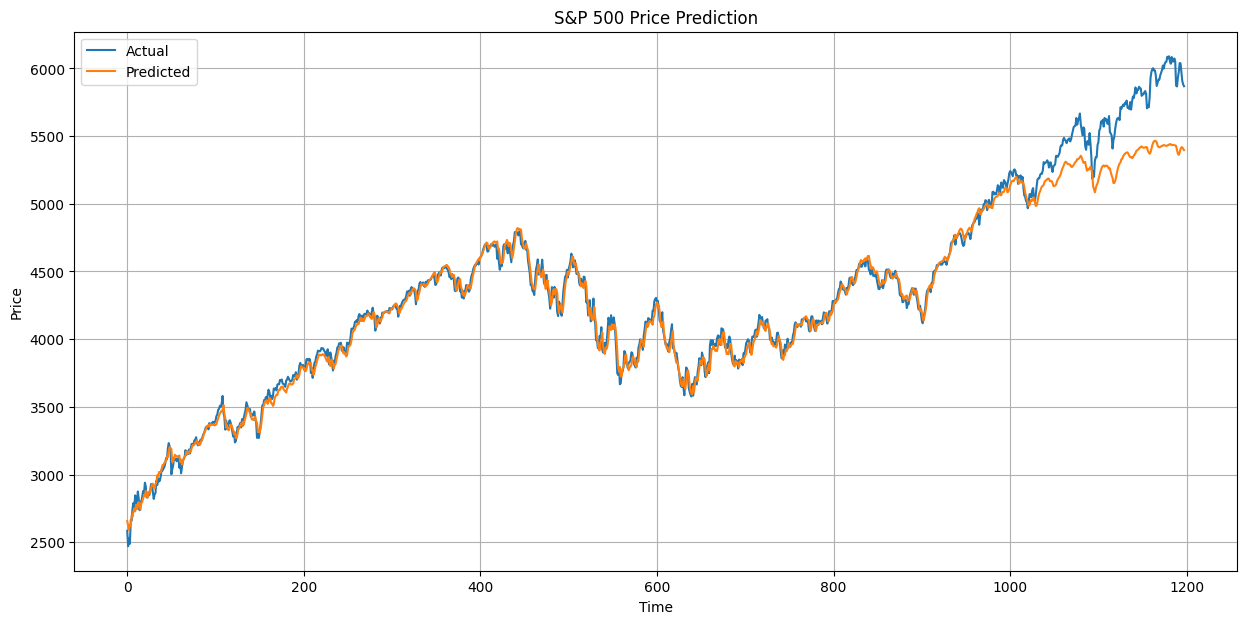

In [2]:
"""
Numerically Stable S&P 500 Stock Price Prediction Model
====================================================
Features gradient clipping, stable normalization, and proper data cleaning
"""

import yfinance as yf
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

class StableStockPredictor:
    def __init__(self, sequence_length=60):  # Reduced sequence length for stability
        self.sequence_length = sequence_length
        self.price_scaler = RobustScaler()
        self.feature_scalers = {}
        self.model = None

    def calculate_stable_features(self, df):
        """
        Calculate features with numerical stability checks
        """
        features = df.copy()

        # Basic price features with safety checks
        features['Returns'] = df['Close'].pct_change().clip(-0.5, 0.5)  # Clip extreme returns
        features['Log_Volume'] = np.log1p(df['Volume'])  # Log transform volume

        # Safe moving averages
        for window in [20, 50]:
            features[f'MA_{window}'] = df['Close'].rolling(window=window, min_periods=1).mean()
            features[f'Std_{window}'] = df['Close'].rolling(window=window, min_periods=1).std()

        # Safe RSI calculation
        delta = df['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14, min_periods=1).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14, min_periods=1).mean()
        rs = gain / loss.replace(0, np.inf)  # Prevent division by zero
        features['RSI'] = 100 - (100 / (1 + rs))
        features['RSI'] = features['RSI'].clip(0, 100)  # Ensure RSI bounds

        # Volatility
        features['Volatility'] = features['Returns'].rolling(window=20, min_periods=1).std()

        # Fill any remaining NaN values
        features = features.fillna(method='ffill').fillna(method='bfill')

        # Final safety check - replace any infinite values
        features = features.replace([np.inf, -np.inf], np.nan)
        features = features.fillna(method='ffill').fillna(0)

        return features

    def prepare_data(self, df):
        """
        Prepare features with robust preprocessing
        """
        print("Preparing features with stability checks...")

        # Calculate features
        features = self.calculate_stable_features(df)

        # Select features for model
        feature_columns = ['Close', 'Returns', 'Log_Volume', 'MA_20', 'MA_50',
                         'Std_20', 'Std_50', 'RSI', 'Volatility']

        # Scale each feature individually
        scaled_features = np.zeros((len(features), len(feature_columns)))

        for i, col in enumerate(feature_columns):
            scaler = RobustScaler()
            scaled_col = scaler.fit_transform(features[col].values.reshape(-1, 1))
            scaled_features[:, i] = scaled_col.ravel()
            self.feature_scalers[col] = scaler

        # Create sequences with stability checks
        X, y = [], []
        for i in range(len(scaled_features) - self.sequence_length):
            X.append(scaled_features[i:(i + self.sequence_length)])
            y.append(scaled_features[i + self.sequence_length, 0])  # Predict scaled Close price

        X = np.array(X)
        y = np.array(y)

        # Final validation of data
        assert not np.isnan(X).any(), "NaN values found in X"
        assert not np.isnan(y).any(), "NaN values found in y"
        assert not np.isinf(X).any(), "Infinite values found in X"
        assert not np.isinf(y).any(), "Infinite values found in y"

        return X, y

    def build_model(self, input_shape):
        """
        Build model with gradient clipping and stable architecture
        """
        inputs = Input(shape=input_shape)

        # Simplified architecture with gradient clipping
        x = LSTM(64, return_sequences=True,
                kernel_initializer='glorot_normal',
                recurrent_initializer='orthogonal',
                bias_initializer='zeros',
                unroll=True)(inputs)
        x = Dropout(0.2)(x)

        x = LSTM(32,
                kernel_initializer='glorot_normal',
                recurrent_initializer='orthogonal',
                bias_initializer='zeros',
                unroll=True)(x)
        x = Dropout(0.2)(x)

        outputs = Dense(1, activation='linear',
                       kernel_initializer='glorot_normal',
                       bias_initializer='zeros')(x)

        model = Model(inputs=inputs, outputs=outputs)

        # Use gradient clipping
        optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
        model.compile(optimizer=optimizer, loss='huber')

        return model

    def train(self, X, y, validation_split=0.2, epochs=50, batch_size=32):
        """
        Train model with stability measures
        """
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        )

        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-5,
            verbose=1
        )

        # Create and compile model
        self.model = self.build_model(input_shape=(X.shape[1], X.shape[2]))

        # Split data
        split_idx = int(len(X) * (1 - validation_split))
        X_train, X_val = X[:split_idx], X[split_idx:]
        y_train, y_val = y[:split_idx], y[split_idx:]

        # Train with smaller batch size for stability
        history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )

        return history

def main():
    # Set seeds
    np.random.seed(42)
    tf.random.set_seed(42)

    # Initialize predictor
    predictor = StableStockPredictor()

    # Download data
    print("Downloading S&P 500 data...")
    data = yf.download('^GSPC', period='5y')

    # Prepare data with stability checks
    X, y = predictor.prepare_data(data)

    # Train model
    history = predictor.train(X, y, epochs=50, batch_size=32)

    # Make predictions if training successful
    if history is not None:
        predictions = predictor.model.predict(X)
        # Inverse transform predictions and actual values
        actual_prices = predictor.feature_scalers['Close'].inverse_transform(y.reshape(-1, 1))
        predicted_prices = predictor.feature_scalers['Close'].inverse_transform(predictions)

        # Calculate metrics
        mse = np.mean((actual_prices - predicted_prices) ** 2)
        rmse = np.sqrt(mse)
        mae = np.mean(np.abs(actual_prices - predicted_prices))
        mape = np.mean(np.abs((actual_prices - predicted_prices) / actual_prices)) * 100

        print("\nModel Performance Metrics:")
        print(f"MSE: {mse:.2f}")
        print(f"RMSE: {rmse:.2f}")
        print(f"MAE: {mae:.2f}")
        print(f"MAPE: {mape:.2f}%")

        # Plot results
        plt.figure(figsize=(15, 7))
        plt.plot(actual_prices, label='Actual')
        plt.plot(predicted_prices, label='Predicted')
        plt.title('S&P 500 Price Prediction')
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True)
        plt.show()

if __name__ == "__main__":
    main()